# Information Propagation Analysis using Machine Learning
Can we use machine learning to better understand the propagation of information? Like ecosystems, information also reproduces, has niches, and is subject to selection pressures. When a piece of information on average propagates to more than one person, it tends to spread exponentially, or "goes viral". The spread of information is relevant everywhere, but in this analysis we'll focus on scientific communication happening on twitter Machine Learning communities.

Two huge factors to consider are the follower count of accounts, and the niche that those accounts are in.

A tweet can go viral in one niche but not others. By specifically looking for "accounts connected to a prominent machine-learning researcher" we can make the assumption that these will mostly represent a "machine learning" niche within the social network.

Correcting for follower count can happen in a few different ways - the first process I tried was to predict the ratio of followers to retweets. This would punish large accounts and boost small accounts, and this simple approach turned out to be ineffective for a number of reasons. A better approach would to look at the curve for how account size relates to average retweet frequency, and normalize for account size. Another simpler approach would be to 'bin' accounts to different follower ranges and only compare them to one-another, say 0-500, 500-1000, 1000-1500, etc. 

Another consideration is that the further back in time you go, the more our "follower count" feature loses accuracy.

## Setup

In [1]:
# !pip install -U sentence-transformers
# !pip install pytorch
# !pip install pytorch-lightning
# !pip install typing-extensions --upgrade
# !pip install tensorboard
# !pip install pytorch-tabnet

# Standard Packages
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os
from pathlib import Path

# NLP Packages
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from top2vec import Top2Vec

# ML Packages
from imblearn.over_sampling import SMOTE, SMOTENC
from xgboost import XGBClassifier
import xgboost
import statsmodels.api as sm
import torch
from pytorch_tabnet.tab_model import TabNetRegressor


from sklearn import metrics, model_selection, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet import preprocess_input
from keras import layers, models, regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout , BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras import optimizers
from tensorflow.keras import Model

np.random.seed(0)

In [195]:
### Model Evaluation Functions

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [log_retweets]')
  plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']), label='Train')
  plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']), label = 'Val')
  plt.legend()
  plt.ylim([0,max(history.history['val_root_mean_squared_error'])])

def plot_prediction(test_labels, test_predictions):
  f = plt.figure(figsize=(8, 4))

  f1 = f.add_subplot(1,2,1)
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [log_retweets]')
  plt.ylabel('Predictions [log_retweets]')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())

  error = test_predictions - test_labels
  f2 = f.add_subplot(1,2,2)
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error [log_retweets]")
  plt.ylabel("Count")
    
  plt.tight_layout()
  plt.show()

### Loading our data
This analysis was done on two separate datasets. For brevity, we'll only cover the first in this notebook, looking at the last 100 tweets with over 1 retweet from the people Andrew Ng is following, and seeing if it's possible to use NLP and machine learning to predict their retweet count.

First we will explore a Top2Vec pipeline to mine data from text, and then later we'll explore raw document embeddings from Roberta-Large, and see how these NLP techniques impact our machine-learning results.

In [58]:
df = pd.read_csv('data/combined_data.csv', index_col=0)
df.shape

(63033, 7)

In [59]:
df.sample(5)

,creation_time,user,tweet,retweets,favorites,followers,lists
17321,2022-05-20 07:54:54+00:00,Smerity,"The key for me was ""Without pretending to pred...",1,7,32666,873
40190,2021-08-06 19:17:48+00:00,bhorowitz,How does @Nas keep dropping classic albums? I ...,43,200,636473,9117
42034,2022-05-08 18:12:26+00:00,melissakorn,Motherhood can be beautiful and heartbreaking ...,3,39,18268,606
30482,2022-09-17 00:20:05+00:00,TensorFlow,📖When incorporating Responsible AI in your ML ...,11,57,341129,4028
16743,2022-05-07 19:44:52+00:00,iamtrask,If one professor hadn't decided to issue an ov...,15,189,67208,1304


,retweets,favorites,followers,lists
retweets,1.000000,0.930035,0.341763,0.277502
favorites,0.930035,1.000000,0.401457,0.324698
followers,0.341763,0.401457,1.000000,0.901672
lists,0.277502,0.324698,0.901672,1.000000


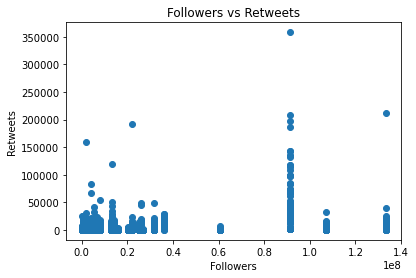

In [60]:
### Interpreting our data:
# Correlation Matrix
display(df.corr())

# scatter plot to show how followers relate to retweets
plt.scatter(df['followers'], df['retweets'])
plt.xlabel('Followers')
plt.ylabel('Retweets')
plt.title('Followers vs Retweets')
plt.show()

We can see that followers and lists seem to have a high correlation with retweets, but much of this is driven by outliers as we'll see after filtering down our data.

# Natural Language Processing
To get the most out of our text data, we'll try a multiscale analysis, each layer getting a bit more abstract. First we'll look at words themselves with a traditional Bag Of Words method, then document embeddings using ROBERTA-large, then topics from Top2Vec. Then we analyze and select our features at every layer of abstraction and integrate with metadata into a final predictive model.

### Bag of Words
The simplest part of our NLP, we will just identify word (or word pairing(bigram)) frequency.

In [102]:
# We'll filter down our words to some range of semi-frequent words
max_doc_frequency = 0.04
min_doc_frequency = 0.004

vectorizer = CountVectorizer(lowercase=True, stop_words={'english'}, ngram_range=(1, 2), max_df=max_doc_frequency, min_df=min_doc_frequency)
docs = df.tweet.tolist()
words = vectorizer.fit_transform(docs)
BOW = pd.DataFrame(words.toarray(), columns=vectorizer.get_feature_names())
BOW = BOW.add_suffix('_BOW')

In [103]:
display(BOW.shape)
BOW.sample(3)

(63033, 940)

,000_BOW,10_BOW,100_BOW,100daysofcode_BOW,11_BOW,12_BOW,15_BOW,19_BOW,20_BOW,2020_BOW,...,you know_BOW,you ll_BOW,you need_BOW,you re_BOW,you to_BOW,you want_BOW,young_BOW,yourself_BOW,youtube_BOW,zero_BOW
33138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Document Embeddings
Check out the other notebook for the document embedding pipeline! We'll just be loading the data here.

In [63]:
### Loading our embeddings
emb = pd.read_csv('data/combined_document_embeddings.csv', index_col=0)
emb = emb.add_suffix('_EMB')

In [64]:
display(emb.shape)
emb.sample(3)

(63033, 1024)

,0_EMB,1_EMB,2_EMB,3_EMB,4_EMB,5_EMB,6_EMB,7_EMB,8_EMB,9_EMB,...,1014_EMB,1015_EMB,1016_EMB,1017_EMB,1018_EMB,1019_EMB,1020_EMB,1021_EMB,1022_EMB,1023_EMB
44173,-0.031071,-0.045788,0.003398,-0.013222,0.019588,-0.031589,-0.043653,-0.013059,-0.001697,-0.054971,...,0.005818,0.017261,0.021145,0.037045,-0.065276,-0.023296,0.023763,0.041899,-0.011696,-0.024266
1404,-0.001090,-0.006708,-0.007952,0.022474,-0.079510,0.013223,-0.000516,-0.039681,0.024145,0.017258,...,-0.027698,-0.009032,-0.040108,-0.025451,-0.029952,0.001002,-0.004326,0.028843,0.010973,0.012300
60000,0.016343,0.006711,-0.040879,0.019481,-0.039547,-0.046462,-0.004161,0.097614,0.001780,0.016255,...,0.013266,-0.012287,0.032432,0.038115,0.014463,-0.002267,0.008946,0.025390,-0.026402,0.015943


### Top2Vec
Same thing here, check out the notebook "Top2Vec_Data_Processing" for the pipeline.

In [169]:
# Import topics
top = pd.read_csv('data/topics.csv', index_col=0)
top = pd.get_dummies(top['topic']).add_suffix('_TOP') # getting dummy columns

In [170]:
display(top.shape)
top.sample(3)

(63033, 448)

,0_TOP,1_TOP,2_TOP,3_TOP,4_TOP,5_TOP,6_TOP,7_TOP,8_TOP,9_TOP,...,438_TOP,439_TOP,440_TOP,441_TOP,442_TOP,443_TOP,444_TOP,445_TOP,446_TOP,447_TOP
58505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our data should be all ready now! We have four different datasets, 'df' contains our metadata and target, 'BOW' contains our bag-of-word data, 'emb' contains our document embeddings from ROBERTA, and 'top' contains our topic vectorization.

---
### Combining all data and filtering outliers

In [210]:
# Joining BOW data
total_df = df.drop(['creation_time', 'user', 'tweet', 'favorites'], axis=1).join(BOW)
display(total_df.shape)

# joining document embeddings
total_df = total_df.join(emb)
display(total_df.shape)

# joining topics
total_df = total_df.join(top)
display(total_df.shape)

# Removing outliers
total_df = total_df.loc[total_df['followers'] <= 50000]
total_df = total_df.loc[total_df['followers'] >= 1000]
total_df = total_df.dropna(axis=1)
total_df = total_df[df['retweets'] <= 1000]
# total_df['retweets'] = np.log1p(total_df['retweets']) # Log Transform of y (target)
display(total_df.shape)

(63033, 943)

(63033, 1967)

(63033, 2415)

C:\Users\8D\AppData\Local\Temp/ipykernel_31380/130863504.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_df = total_df[df['retweets'] <= 1000]


(28914, 2415)

### Linear Regression Baseline on Combined Data

In [211]:
X = total_df.drop(['retweets'], axis=1)
y = total_df['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
meta_pred = linreg.predict(X_test); linreg_rmse = np.sqrt(MSE(y_test, meta_pred)); print("LR RMSE : % f" %(linreg_rmse))

LR RMSE :  24.421417


### XGBoost Baseline on Combined Data

In [202]:
start = datetime.datetime.now()

progress = dict()
eval_set = [(X_test, y_test)]
eval_metric = ["rmse"]

XGB = xgboost.XGBRegressor(early_stopping_rounds=10) # , early_stopping_rounds=1
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)

end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

[0]	validation_0-rmse:23.93613
[1]	validation_0-rmse:23.55464
[2]	validation_0-rmse:23.80824
[3]	validation_0-rmse:23.87297
[4]	validation_0-rmse:23.98737
[5]	validation_0-rmse:24.15281
[6]	validation_0-rmse:24.15926
[7]	validation_0-rmse:24.17770
[8]	validation_0-rmse:24.25719
[9]	validation_0-rmse:24.34170
[10]	validation_0-rmse:24.39722
Training took a total of 0:00:10.395104
{}


Here we can see our XGBoost baseline is actually getting worse on our combined data. With this much data, we are definitely overfitting.

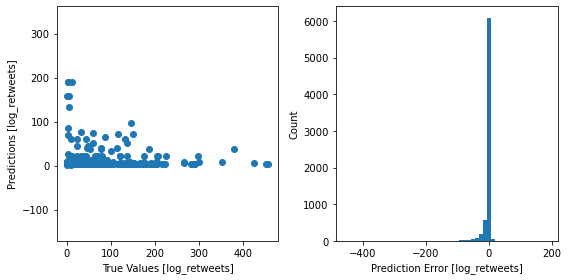

In [207]:
test_predictions = XGB.predict(X_test).flatten()
plot_prediction(y_test, test_predictions)

# Baselines for split Data
One thing we can try is an ensemble model, where we perform machine learning on each of our Natural Language Processing datasets (as well as metadata) and combine them. Let's try a Linear Regression baseline for each dataset considered separately.

In [163]:
# Data Preparation - filtering outliers for high/low follower count, and extremely high retweet count
filtered_df = df.loc[df['followers'] <= 50000].dropna(axis=1)
filtered_df = filtered_df.loc[filtered_df['followers'] >= 1000]
filtered_df = filtered_df[filtered_df['retweets'] <= 1000]
# filtered_df['retweets'] = np.log1p(filtered_df['retweets']) # Log Transform of y (target)

### Metadata Baseline

In [164]:
# Data Preparation
X = filtered_df[['followers', 'lists']]
y = filtered_df['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
meta_pred = linreg.predict(X_test); linreg_rmse = np.sqrt(MSE(y_test, meta_pred)); print("LR RMSE : % f" %(linreg_rmse))

LR RMSE :  23.154065


### Bag Of Words Baseline

In [165]:
# Filtering Data
bow_filtered = filtered_df[['retweets']].join(BOW)

# Data Preparation
X = bow_filtered.drop(['retweets'], axis=1)
y = bow_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
bow_pred = linreg.predict(X_test); linreg_rmse = np.sqrt(MSE(y_test, bow_pred)); print("LR RMSE : % f" %(linreg_rmse))

LR RMSE :  23.480091


### Document Embeddings Baseline

In [166]:
# Filtering Data
emb_filtered = filtered_df[['retweets']].join(emb)

# Data Preparation
X = emb_filtered.drop(['retweets'], axis=1)
y = emb_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
emb_pred = linreg.predict(X_test); linreg_rmse = np.sqrt(MSE(y_test, emb_pred)); print("LR RMSE : % f" %(linreg_rmse))

LR RMSE :  23.918626


### Topic Vectorization Baseline

In [167]:
# Filtering Data
top_filtered = filtered_df[['retweets']].join(top)

# Data Preparation
X = top_filtered.drop(['retweets'], axis=1)
y = top_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
linreg = LinearRegression().fit(X_train, y_train)
top_pred = linreg.predict(X_test); linreg_rmse = np.sqrt(MSE(y_test, top_pred)); print("LR RMSE : % f" %(linreg_rmse))

LR RMSE :  23.050944


We can see that every one of these split models outperform both of our combined model baselines. What if we create an ensemble from our predictions?

### Ensemble Baseline

In [168]:
ensemble = pd.DataFrame([meta_pred, bow_pred, emb_pred, top_pred]).transpose().mean(axis=1)
ensemble_rmse = np.sqrt(MSE(y_test, ensemble)); print("LR RMSE : % f" %(ensemble_rmse))

LR RMSE :  22.423325


A RMSE of 22.42 beats each of our models individually. Again, that's a considerable improvement! This means that on average, our model predicts the retweet count to within 22.4 retweets. What if we tried this ensemble technique with a better performing machine learning algorithm?

## XGBoost Ensemble

### Metadata XGBoost

In [218]:
# Data Preparation
X = filtered_df[['followers', 'lists']]
y = filtered_df['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_test, y_test)]; val_metric = ["rmse"]
XGB = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed));
meta_pred = XGB.predict(X_test); rmse = np.sqrt(MSE(y_test, meta_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:23.26245
[1]	validation_0-rmse:22.53909
[2]	validation_0-rmse:22.25665
[3]	validation_0-rmse:22.15203
[4]	validation_0-rmse:22.01560
[5]	validation_0-rmse:21.96984
[6]	validation_0-rmse:21.97678
[7]	validation_0-rmse:21.97478
[8]	validation_0-rmse:21.94790
[9]	validation_0-rmse:21.94762
[10]	validation_0-rmse:21.94504
[11]	validation_0-rmse:21.93984
[12]	validation_0-rmse:21.91395
[13]	validation_0-rmse:21.93312
[14]	validation_0-rmse:21.92050
[15]	validation_0-rmse:21.91806
[16]	validation_0-rmse:21.91518
[17]	validation_0-rmse:21.90769
[18]	validation_0-rmse:21.90264
[19]	validation_0-rmse:21.88974
[20]	validation_0-rmse:21.88780
[21]	validation_0-rmse:21.88503
[22]	validation_0-rmse:21.88559
[23]	validation_0-rmse:21.88191
[24]	validation_0-rmse:21.87945
[25]	validation_0-rmse:21.88131
[26]	validation_0-rmse:21.87360
[27]	validation_0-rmse:21.87497
[28]	validation_0-rmse:21.86956
[29]	validation_0-rmse:21.87210
[30]	validation_0-rmse:21.87137
[31]	validation_0-

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:21.87087
[40]	validation_0-rmse:21.86607
[41]	validation_0-rmse:21.86566
[42]	validation_0-rmse:21.86727
[43]	validation_0-rmse:21.86914
[44]	validation_0-rmse:21.86659
[45]	validation_0-rmse:21.86348
[46]	validation_0-rmse:21.86614
[47]	validation_0-rmse:21.86566
[48]	validation_0-rmse:21.86711
[49]	validation_0-rmse:21.86698
[50]	validation_0-rmse:21.86879
[51]	validation_0-rmse:21.86918
[52]	validation_0-rmse:21.86962
[53]	validation_0-rmse:21.87043
[54]	validation_0-rmse:21.87088
[55]	validation_0-rmse:21.87058
[56]	validation_0-rmse:21.87199
[57]	validation_0-rmse:21.87407
[58]	validation_0-rmse:21.87367
[59]	validation_0-rmse:21.87329
[60]	validation_0-rmse:21.87308
[61]	validation_0-rmse:21.87339
[62]	validation_0-rmse:21.87339
[63]	validation_0-rmse:21.87474
[64]	validation_0-rmse:21.87497
[65]	validation_0-rmse:21.87597
Training took a total of 0:00:00.296999
RMSE :  21.863483


### BOW XGBoost

In [222]:
# Filtering Data
bow_filtered = filtered_df[['retweets']].join(BOW)

# Data Preparation
X = bow_filtered.drop(['retweets'], axis=1)
y = bow_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_test, y_test)]; val_metric = ["rmse"]
XGB = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
bow_pred = XGB.predict(X_test); rmse = np.sqrt(MSE(y_test, bow_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:23.71449


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:23.28826
[2]	validation_0-rmse:22.97264
[3]	validation_0-rmse:22.85073
[4]	validation_0-rmse:22.74760
[5]	validation_0-rmse:22.75313
[6]	validation_0-rmse:22.74142
[7]	validation_0-rmse:22.75677
[8]	validation_0-rmse:22.70442
[9]	validation_0-rmse:22.68838
[10]	validation_0-rmse:22.71635
[11]	validation_0-rmse:22.79533
[12]	validation_0-rmse:22.80510
[13]	validation_0-rmse:22.81882
[14]	validation_0-rmse:22.82485
[15]	validation_0-rmse:22.82441
[16]	validation_0-rmse:22.84515
[17]	validation_0-rmse:22.93237
[18]	validation_0-rmse:22.94121
[19]	validation_0-rmse:22.93579
[20]	validation_0-rmse:22.93034
[21]	validation_0-rmse:23.00708
[22]	validation_0-rmse:23.03486
[23]	validation_0-rmse:23.08534
[24]	validation_0-rmse:23.09333
[25]	validation_0-rmse:23.19944
[26]	validation_0-rmse:23.26213
[27]	validation_0-rmse:23.26192
[28]	validation_0-rmse:23.27322
[29]	validation_0-rmse:23.31868
Training took a total of 0:00:03.432001
{}
RMSE :  22.688382


### Embeddings XGBoost

In [223]:
# Filtering Data
emb_filtered = filtered_df[['retweets']].join(emb)

# Data Preparation
X = emb_filtered.drop(['retweets'], axis=1)
y = emb_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_test, y_test)]; val_metric = ["rmse"]
XGB = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
emb_pred = XGB.predict(X_test); rmse = np.sqrt(MSE(y_test, emb_pred)); print("RMSE : % f" %(rmse))

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:24.11383
[1]	validation_0-rmse:24.10377
[2]	validation_0-rmse:24.03130
[3]	validation_0-rmse:24.15191
[4]	validation_0-rmse:24.30792
[5]	validation_0-rmse:24.51327
[6]	validation_0-rmse:24.79774
[7]	validation_0-rmse:24.77931
[8]	validation_0-rmse:24.80206
[9]	validation_0-rmse:24.92855
[10]	validation_0-rmse:25.07875
[11]	validation_0-rmse:25.14159
[12]	validation_0-rmse:25.19136
[13]	validation_0-rmse:25.22130
[14]	validation_0-rmse:25.22364
[15]	validation_0-rmse:25.22607
[16]	validation_0-rmse:25.22388
[17]	validation_0-rmse:25.33567
[18]	validation_0-rmse:25.39930
[19]	validation_0-rmse:25.47790
[20]	validation_0-rmse:25.48554
[21]	validation_0-rmse:25.53429
Training took a total of 0:00:13.873056
{}
RMSE :  24.031296


### Topic Vectorization XGBoost

In [224]:
# Filtering Data
top_filtered = filtered_df[['retweets']].join(top)

# Data Preparation
X = top_filtered.drop(['retweets'], axis=1)
y = top_filtered['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# XGBoost model
start = datetime.datetime.now(); progress = dict()
eval_set = [(X_test, y_test)]; val_metric = ["rmse"]
XGB = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
end = datetime.datetime.now(); elapsed = end-start

# Report
print('Training took a total of {}'.format(elapsed)); print(progress)
top_pred = XGB.predict(X_test); rmse = np.sqrt(MSE(y_test, top_pred)); print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:23.71361
[1]	validation_0-rmse:23.29061
[2]	validation_0-rmse:23.08783


C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:22.98062
[4]	validation_0-rmse:22.94216
[5]	validation_0-rmse:22.91856
[6]	validation_0-rmse:22.90231
[7]	validation_0-rmse:22.89068
[8]	validation_0-rmse:22.90885
[9]	validation_0-rmse:22.90136
[10]	validation_0-rmse:22.89302
[11]	validation_0-rmse:22.88622
[12]	validation_0-rmse:22.88307
[13]	validation_0-rmse:22.88605
[14]	validation_0-rmse:22.90046
[15]	validation_0-rmse:22.90438
[16]	validation_0-rmse:22.89486
[17]	validation_0-rmse:22.89905
[18]	validation_0-rmse:22.88952
[19]	validation_0-rmse:22.89242
[20]	validation_0-rmse:22.89408
[21]	validation_0-rmse:22.90003
[22]	validation_0-rmse:22.91006
[23]	validation_0-rmse:22.91717
[24]	validation_0-rmse:22.91420
[25]	validation_0-rmse:22.91818
[26]	validation_0-rmse:22.91184
[27]	validation_0-rmse:22.91448
[28]	validation_0-rmse:22.91208
[29]	validation_0-rmse:22.90898
[30]	validation_0-rmse:22.90988
[31]	validation_0-rmse:22.90892
[32]	validation_0-rmse:22.91193
Training took a total of 0:00:01.845999
{}
RMSE

### XGBoost Ensemble

In [225]:
ensemble = pd.DataFrame([meta_pred, bow_pred, emb_pred, top_pred]).transpose().mean(axis=1)
ensemble_rmse = np.sqrt(MSE(y_test, ensemble)); print("LR RMSE : % f" %(ensemble_rmse))

LR RMSE :  22.078832


Here our results are more complicated. XGBoost on just metadata outperformed all of our other models, including our ensemble models. It looks like that's our new baseline - can we use NLP to beat predictions from metadata alone? Can we construct our ensemble model in a different way to maximize the different predictive powers of metadata and NLP?

## TabNet
TabNet is a deep learning system developed by google that can reportedy beat XGBoost on Tabular Data

In [233]:
clf = TabNetRegressor()
max_epochs = 50 if not os.getenv("CI", False) else 2

C:\Users\8D\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [280]:
# Filtering Data
tabnet_data = filtered_df[['retweets']].join(BOW).join(top).join(emb)

# Data Preparation
X = tabnet_data.drop(['retweets'], axis=1)
y = tabnet_data['retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Converting to Numpy Arrays
X_train = X_train.values
y_train = y_train.values.reshape(-1, 1)
X_test = X_test.values
y_test = y_test.values.reshape(-1, 1)

In [282]:
max_epochs = 100 if not os.getenv("CI", False) else 2

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['mae', 'rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
) 

KeyboardInterrupt: 

In [279]:
preds = clf.predict(X_test)
test_score = MSE(y_pred=preds, y_true=y_test)

print(f"FINAL TEST RMSE FOR DATA : {np.sqrt(test_score)}")

FINAL TEST RMSE FOR DATA : 22.86256453071145


## Splitting data to X and y

In [22]:
# Assigning X and y values
# Note the comment about dropping followers and lists too
# X = df_dummies.drop(['retweets', 'favorites', 'tweet', 'user', 'creation_time', 'followers', 'lists'], axis=1) #
X = df_features.drop(['retweets'], axis=1) #
y = df_features['retweets']

In [277]:
# # Run this cell if you're using our feature selection
# X = df_features.drop('retweets', axis=1)
# y = df_features['retweets']

In [23]:
# Log transform of y
y_log = np.log1p(y)

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=42)

# Creating Validation Set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

In [24]:
X_train

,followers,lists,00_BOW,000_BOW,10_BOW,100_BOW,100daysofcode_BOW,11_BOW,12_BOW,13_BOW,...,438_TOP,439_TOP,440_TOP,441_TOP,442_TOP,443_TOP,444_TOP,445_TOP,446_TOP,447_TOP
50811,1359,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41513,7359,206,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4442,21497,263,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43618,33971,820,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26911,3618,111,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59828,2748,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47403,6910,236,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51489,3680,102,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18573,8736,97,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Machine Learning
Our data should be prepped and ready for machine learning! We'll compare five different models in two rounds, then pick one or two to iterate further. The first round will be untuned, the second round will be after some tuning.

## Linear Regression Baseline

In [25]:
linreg = LinearRegression().fit(X_train, y_train)

print('Training Accuracy: {:.4}%'.format(linreg.score(X_train, y_train) * 100))
print('Validation accuracy: {:.4}%'.format(linreg.score(X_val, y_val) * 100))

pred = linreg.predict(X_val)
linreg_rmse = np.sqrt(MSE(y_val, pred))
print("LR RMSE : % f" %(linreg_rmse))

Training Accuracy: 45.53%
Validation accuracy: 8.478%
LR RMSE :  0.917642


## XGBoost Baseline

In [26]:
start = datetime.datetime.now()

progress = dict()
eval_set = [(X_val, y_val)]
eval_metric = ["rmse","mae"]

XGB = xgboost.XGBRegressor(objective='reg:squarederror') # , early_stopping_rounds=1
XGBhist = XGB.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, )

end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.14329	validation_0-mae:0.75138
[1]	validation_0-rmse:1.01575	validation_0-mae:0.67335
[2]	validation_0-rmse:0.94474	validation_0-mae:0.64182
[3]	validation_0-rmse:0.90574	validation_0-mae:0.62920
[4]	validation_0-rmse:0.88184	validation_0-mae:0.62379
[5]	validation_0-rmse:0.87016	validation_0-mae:0.62419
[6]	validation_0-rmse:0.86324	validation_0-mae:0.62465
[7]	validation_0-rmse:0.85819	validation_0-mae:0.62420
[8]	validation_0-rmse:0.85481	validation_0-mae:0.62462
[9]	validation_0-rmse:0.85114	validation_0-mae:0.62397
[10]	validation_0-rmse:0.84963	validation_0-mae:0.62393
[11]	validation_0-rmse:0.85031	validation_0-mae:0.62573
[12]	validation_0-rmse:0.85015	validation_0-mae:0.62630
[13]	validation_0-rmse:0.84915	validation_0-mae:0.62563
[14]	validation_0-rmse:0.84934	validation_0-mae:0.62610
[15]	validation_0-rmse:0.84767	validation_0-mae:0.62510
[16]	validation_0-rmse:0.84772	validation_0-mae:0.62508
[17]	validation_0-rmse:0.84763	validation_0-mae:0.62512
[1

In [27]:
# Accuracy of training and val sets
print('Training Accuracy: {:.4}%'.format(XGB.score(X_train, y_train) * 100))
print('Validation accuracy: {:.3}%'.format(XGB.score(X_val, y_val) * 100))

pred = XGB.predict(X_val)
xgb_rmse = np.sqrt(MSE(y_val, pred))
print("XGB RMSE : % f" %(xgb_rmse))

Training Accuracy: 84.36%
Validation accuracy: 21.8%
XGB RMSE :  0.848004


## Random Forest Regressor

In [28]:
# Timing
start = datetime.datetime.now()

# Instantiate and fit a RandomForest Regressor
forest = RandomForestRegressor(max_depth=8, n_estimators=200)
forest.fit(X_train, y_train)

# Timing
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:25:47.662213


In [29]:
# Training and Testing accuracy score
print('Training Accuracy: {:.4}%'.format(forest.score(X_train, y_train) * 100))
print('Validation accuracy: {:.4}%'.format(forest.score(X_test, y_test) * 100))

pred = forest.predict(X_val)
forest_rmse = np.sqrt(MSE(y_val, pred))
print("RF RMSE : % f" %(forest_rmse))

Training Accuracy: 36.43%
Validation accuracy: 19.15%
RF RMSE :  0.859512


## Deep Learning

In [289]:
# Establish our metrics
METRICS = [tf.keras.metrics.MeanAbsoluteError(),
           tf.keras.metrics.RootMeanSquaredError()]

In [296]:
def build_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),                  
    keras.layers.Dense(64, activation=tf.nn.crelu), # tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation=tf.nn.crelu), # tf.keras.layers.Dropout(0.05),
    keras.layers.Dense(1)
  ], name="MLP_model")

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=METRICS)
  return model

deep_1 = build_model()
# deep_1.summary()

In [297]:
# Timing
start = datetime.datetime.now()

EPOCHS = 5
# Store training stats
deep_hist_1 = deep_1.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

# Timing
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Epoch 1/5
407/407 [==============================] - 1s 1ms/step - loss: 0.9745 - mean_absolute_error: 0.7407 - root_mean_squared_error: 1.0070 - val_loss: 1.2958 - val_mean_absolute_error: 0.7514 - val_root_mean_squared_error: 1.1383
Epoch 2/5
407/407 [==============================] - 0s 1ms/step - loss: 0.8431 - mean_absolute_error: 0.6833 - root_mean_squared_error: 0.9182 - val_loss: 0.8821 - val_mean_absolute_error: 0.6717 - val_root_mean_squared_error: 0.9392
Epoch 3/5
407/407 [==============================] - 1s 1ms/step - loss: 0.8043 - mean_absolute_error: 0.6683 - root_mean_squared_error: 0.8968 - val_loss: 0.8766 - val_mean_absolute_error: 0.6860 - val_root_mean_squared_error: 0.9363
Epoch 4/5
407/407 [==============================] - 1s 1ms/step - loss: 0.7874 - mean_absolute_error: 0.6613 - root_mean_squared_error: 0.8874 - val_loss: 0.8797 - val_mean_absolute_error: 0.6829 - val_root_mean_squared_error: 0.9379
Epoch 5/5
407/407 [==============================] - 1s 1ms/

Train RMSE:  0.8924
Val RMSE:  0.9621


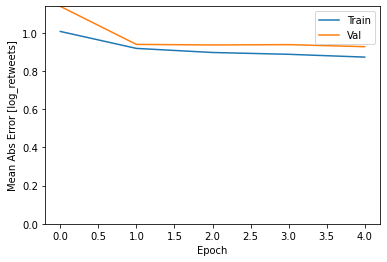

In [298]:
plot_history(deep_hist_1)

train_score = deep_1.evaluate(X_train, y_train, verbose = 0) 
# print('Val loss:', score[0]) 
print('Train RMSE:  {:.4}'.format(train_score[2]))

val_score = deep_1.evaluate(X_val, y_val, verbose = 0) 
# print('Val loss:', score[0]) 
print('Val RMSE:  {:.4}'.format(val_score[2]))

## Comparing our Baselines

Linear Regression Predictions:
Linear Regression Validation RMSE :  0.897655


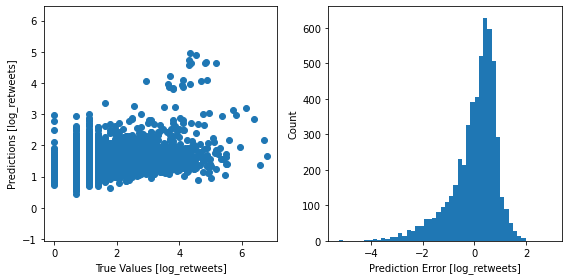

XGBoost Predictions:
XGBoost Validation RMSE :  0.929571


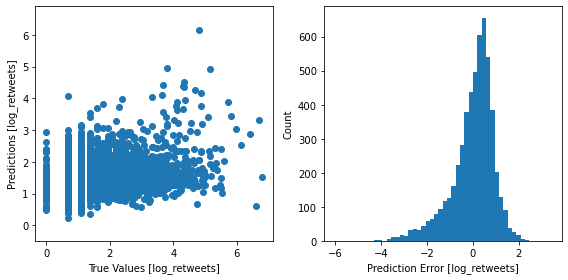

Random Forest Predictions:
RF Validation RMSE :  0.912194


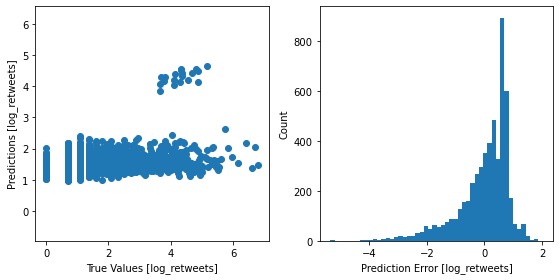

Deep Learning Predictions:


InvalidArgumentError: Graph execution error:

Detected at node 'MLP_model/dense_9/BiasAdd' defined at (most recent call last):
    File "C:\Users\8D\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\8D\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\8D\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\8D\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\8D\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\8D\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\8D\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\8D\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\8D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\8D\AppData\Local\Temp/ipykernel_16632/174559341.py", line 26, in <module>
      train_score = deep_1.evaluate(X_train, y_train, verbose = 0)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\8D\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 232, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'MLP_model/dense_9/BiasAdd'
Matrix size-incompatible: In[0]: [32,97], In[1]: [299,64]
	 [[{{node MLP_model/dense_9/BiasAdd}}]] [Op:__inference_test_function_249444]

In [288]:
# Comparing all three models
print('Linear Regression Predictions:')
val_predictions = linreg.predict(X_val).flatten()
linreg_rmse = np.sqrt(MSE(y_val, val_predictions))
print("Linear Regression Validation RMSE : % f" %(linreg_rmse))
val_predictions = linreg.predict(X_val).flatten()
plot_prediction(y_val, val_predictions)
plt.show()

print('XGBoost Predictions:')
val_predictions = XGB.predict(X_val).flatten()
xgb_rmse = np.sqrt(MSE(y_val, val_predictions))
print("XGBoost Validation RMSE : % f" %(xgb_rmse))
val_predictions = XGB.predict(X_val).flatten()
plot_prediction(y_val, val_predictions)
plt.show()

print('Random Forest Predictions:')
val_predictions = forest.predict(X_val).flatten()
forest_rmse = np.sqrt(MSE(y_val, val_predictions))
print("RF Validation RMSE : % f" %(forest_rmse))
plot_prediction(y_val, val_predictions)
plt.show()

print('Deep Learning Predictions:')
train_score = deep_1.evaluate(X_train, y_train, verbose = 0) 
print('Deep Learning Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = deep_1.predict(X_val).flatten()
plot_prediction(y_val, val_predictions)

# Hyperparameter Tuning for Top2Vec models
Linear Regression doesn't have hyperparameters to tune, so we'll start with XGBoost

In [68]:
optimize = 'neg_root_mean_squared_error'

In [69]:
# Our hyperparameter grid, with some other options as comments

XGB = xgboost.XGBRegressor(objective='reg:squarederror')

XGB_params = {
    'learning_rate' : [0.3],
    'min_child_weight' : [4],
#     'gamma' : [0.0, 0.1, 0.2 , 0.3],
    'colsample_bytree' : [0.5],
#     'alpha' : [0.01], # L1 regularization
#     'eta': [1, 0.5],
    'eval_metric':['mlogloss'],
    'lambda':[1], # L2 regularization
    'booster' : ['gbtree'],
    'max_depth': [5],
    'n_estimators': [130],
#     'subsample': [0.5]
}

start = datetime.datetime.now()

# Searching Parameters
XGB3 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=3, n_jobs=1, verbose=True)
XGB3.fit(X_train, y_train)

XGB_best_parameters = XGB3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(XGB_best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search found the following optimal parameters: 
booster: 'gbtree'
colsample_bytree: 0.5
eval_metric: 'mlogloss'
lambda: 1
learning_rate: 0.3
max_depth: 5
min_child_weight: 4
n_estimators: 130
Training took a total of 0:00:09.678518
{}


In [70]:
# Validation RMSE
pred3 = XGB3.predict(X_val)
xgb_rmse = np.sqrt(MSE(y_val, pred3))
print("XGB RMSE : % f" %(xgb_rmse))

XGB RMSE :  0.918140


## Random Forest Hyperparameter tuning

In [71]:
# Our hyperparameter grid, with some other options as comments
rf_params = {
    'bootstrap' : [True],
    'max_features' : ['auto'],
    'max_depth' : [None],
    'n_estimators' : [100]
}

start = datetime.datetime.now()

# Searching parameters
forest3 = GridSearchCV(RandomForestRegressor(), rf_params, scoring='neg_root_mean_squared_error', cv=2, n_jobs=1)
forest3.fit(X_train, y_train)

rf_best_params = forest3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(rf_best_params.keys()):
    print('%s: %r' % (param_name, rf_best_params[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Grid Search found the following optimal parameters: 
bootstrap: True
max_depth: None
max_features: 'auto'
n_estimators: 100
Training took a total of 0:05:33.044936


In [72]:
# Validation RMSE
pred3 = forest3.predict(X_val)
forest_rmse = np.sqrt(MSE(y_val, pred3))
print("Forest RMSE : % f" %(forest_rmse))

Forest RMSE :  0.897809


## Hyperparameter Tuning Analysis

In [ ]:
print('XGBoost Predictions:')
val_predictions = XGB.predict(X_val).flatten()
xgb_rmse = np.sqrt(MSE(y_val, val_predictions))
print("XGBoost Validation RMSE : % f" %(xgb_rmse))
val_predictions = XGB.predict(X_val).flatten()
plot_prediction(y_val, val_predictions)
plt.show()

print('Random Forest Predictions:')
val_predictions = forest.predict(X_val).flatten()
forest_rmse = np.sqrt(MSE(y_val, val_predictions))
print("RF Validation RMSE : % f" %(forest_rmse))
plot_prediction(y_val, val_predictions)
plt.show()

It looks like of these models, XGBoost and Random Forest models performed the best on our data. Going forward, to improve our predictive power, we can either change the data we are feeding these algorithms, or the algorithms themselves.

Changing our data means either changing our data collection strategy, or changing our data preparation and feature-engineering. For the purposes of this analysis, our central question is how semantic content influences virality of information. Top2Vec has given us a baseline, and shows that there is some correlation between topics and virality. It seems likely that if we had a better model for the meaning of language, we might have a better way to predict which statements go viral. The next level of complexity for natural language processing is to look at "document embeddings."

One of the main ways to derive document embeddings is by leveraging a large pretrained model (like BERT) which has been used to analyze lots and lots of text to determine principle components or important semantic vectors. These vectors can then be used as measures of similarity between sentences or documents. We already did some document embedding in our Top2Vec pipeline, but will our models perform better if we: 1.) use more document embeddings with a larger language model (ROBERTA), and 2.) feed the raw vector data to our machine learning models? Let's find out!

## Roberta Embedding Extraction
Here's where we'll analyze our documents using [ROBERTA](https://huggingface.co/transformers/v2.9.1/model_doc/roberta.html), a large pretrained language model.

This stage takes a lot of processing, on my computer this section took 6 hours to run! I have the document embeddings available on request, or you could run this section overnight to get the same embeddings.

In [25]:
# ### Takes hours to run this cell!
# start = datetime.datetime.now()

# model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
# embeddings = model.encode(docs) # Note that we're reusing 'docs' from the top2vec 

# end = datetime.datetime.now(); elapsed = end-start
# print('Training took a total of {}'.format(elapsed))

In [5]:
# ### Saving our embeddings
# pd.DataFrame(embeddings).to_csv('ng_embeddings.csv')

### Loading our embeddings
emb = pd.read_csv('data/ng_embeddings.csv', index_col=0)

In [8]:
emb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.005032,-0.030947,-0.006062,0.047324,-0.055165,-0.057167,-0.030257,-0.031478,0.055101,0.022555,...,-0.010593,0.060685,0.012057,0.050567,-0.049132,-0.028009,-0.038905,-0.025987,0.004756,-0.034641
1,-0.017376,-0.004529,-0.010203,0.036250,-0.015020,0.017352,-0.022352,-0.022748,0.032929,0.027165,...,0.004835,0.057194,0.040557,0.032773,-0.031219,-0.043274,-0.021079,-0.008907,0.009224,-0.024085
2,-0.042825,-0.020346,-0.008057,0.014741,-0.019099,-0.007700,-0.026105,-0.042662,0.036060,0.011172,...,0.024967,0.033303,0.043724,0.027738,-0.062944,-0.028252,-0.003424,0.017833,0.011276,0.048103


Principle Component Analysis is very useful for us to filter down our features, increasing our model speed and accuracy by minimizing multicollinearity!

In [6]:
# Principle Component Analysis -- RUNNING THIS CELL MORE THAN ONCE CAN CAUSE PROBLEMS --
pca = PCA(n_components=256)
emb_pca = pca.fit_transform(emb)
emb_pca = pd.DataFrame(emb_pca)

In [7]:
emb_pca.head(3)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.302150,-0.057887,-0.101407,-0.000749,-0.058885,-0.013129,0.081130,-0.206353,0.108440,-0.005820,...,-0.004228,-0.061090,0.015971,0.014438,-0.035498,-0.010885,0.018600,-0.007072,0.012611,0.006123
1,0.123581,0.138708,-0.163301,0.083789,-0.183423,0.151625,0.126398,-0.162715,-0.107949,-0.064109,...,-0.002569,-0.026643,0.013468,-0.017201,0.023292,0.005852,0.010911,-0.000127,-0.013687,0.027662
2,0.284664,0.389809,-0.187073,-0.008677,0.021548,-0.047239,-0.086756,-0.250323,-0.110190,-0.004221,...,-0.032440,0.002358,0.012697,-0.012938,-0.048768,-0.009406,0.026641,-0.024035,0.005489,0.026206


## Turning Document Embeddings into Training Data
When we look at this data, each row corresponds to a tweet with 1024 different columns of semantic association.

In [60]:
# Filtering down to just documents between 5 and 50 thousand followers
df = pd.read_csv('data/ng_friend_tweets.csv', index_col=0)
filtered = df[['followers', 'lists', 'retweets']].join(emb_pca)
filtered = filtered.loc[filtered['followers'] < 50000].loc[filtered['followers'] > 5000]
filtered_df = filtered.drop(['retweets'], axis=1)

In [67]:
# Normalizing followers and lists columns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
filtered_df[['followers', 'lists']] = scaler.fit_transform(filtered_df[['followers', 'lists']])

In [108]:
filtered_df

,followers,lists,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
195,0.735742,0.297035,-0.021253,0.196070,0.108836,0.009545,0.126497,0.364913,-0.075109,-0.036550,...,-0.014430,-0.003448,0.024183,-0.014651,-0.034393,-0.031589,0.032391,-0.007780,0.020987,-0.036631
196,0.735742,0.297035,0.242462,0.266910,-0.138842,-0.002129,0.144411,0.000816,-0.088337,-0.204370,...,0.018464,-0.012420,-0.001123,-0.018264,0.010540,-0.009843,0.016405,-0.027341,0.008196,-0.012217
197,0.735742,0.297035,0.045698,0.413429,-0.138450,0.005729,0.253127,0.016676,-0.068474,-0.237227,...,0.000367,-0.009567,0.036470,-0.022533,-0.004594,-0.006371,-0.004413,0.001972,-0.036398,-0.019882
198,0.735742,0.297035,0.225201,0.072460,-0.013669,0.008931,-0.127521,0.090898,0.243644,0.063626,...,-0.061864,0.028202,-0.000050,0.067390,-0.016645,0.002959,-0.010566,0.013866,0.001951,0.016211
199,0.735742,0.297035,0.336097,0.010745,-0.107828,0.155454,-0.021747,-0.018535,-0.005195,-0.201158,...,-0.029632,-0.001497,-0.002184,0.055669,-0.033577,-0.006628,0.057648,0.026969,-0.020362,-0.007139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45488,0.035152,0.080700,0.214227,-0.128694,-0.075616,0.040383,0.176813,0.014190,0.116881,0.244904,...,-0.030724,-0.001708,0.028958,0.015300,0.021365,0.022486,0.002817,0.007697,0.006290,0.006981
45489,0.035152,0.080700,0.069834,0.010011,0.113053,-0.186331,-0.035229,-0.138606,-0.003519,0.313665,...,0.011875,0.027322,0.025227,0.024604,-0.054596,-0.022006,0.032286,-0.023403,-0.047468,-0.026898
45490,0.035152,0.080700,0.290125,-0.160100,-0.010381,0.100232,0.218831,-0.090160,0.022140,0.075849,...,-0.001666,-0.000956,0.002039,0.016580,0.061105,-0.034960,-0.013718,-0.004340,-0.005004,0.027581
45491,0.035152,0.080700,0.167535,-0.024694,-0.269161,0.045780,0.091376,0.138483,0.272396,0.117616,...,0.023387,0.026087,-0.030280,-0.022133,0.034936,-0.009135,-0.001371,0.005564,-0.031319,0.008649


Now we'll need to recreate our train-val-test split.

In [69]:
# Data and Target Split
# X2 = emb # df[['followers', 'lists']].join(emb) # Uncomment to train on raw document embeddings
X2 = filtered_df
y = filtered['retweets'] # This is the same as our original y

# Log transform of y
y_log = np.log1p(y)

# Train-test Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y_log, random_state=42)

# Creating Validation Set
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, random_state=42)

And now we can try this new data on our baseline models and see how their results compare.

# Baselines for Document Embedding Models

## Linear Regression Baseline

In [109]:
linreg2 = LinearRegression().fit(X_train2, y_train2)

print('Training Accuracy: {:.4}%'.format(linreg2.score(X_train2, y_train2) * 100))
print('Validation accuracy: {:.4}%'.format(linreg2.score(X_val2, y_val2) * 100))

pred2 = linreg2.predict(X_val2)
linreg_rmse2 = np.sqrt(MSE(y_val2, pred2))
print("LR RMSE : % f" %(linreg_rmse2))

Training Accuracy: 21.11%
Validation accuracy: 16.91%
LR RMSE :  0.938536


In [76]:
# ### Logistic Regression Baseline
# X_train_const = sm.add_constant(X_train) # Adding constant
# log_reg = sm.OLS(y_train, X_train_const) # defining model parameters

# results = log_reg.fit() # Fitting model
# results.summary() # Peeping summary

## XGBoost Baseline

In [77]:
start = datetime.datetime.now()

progress = dict()
eval_set = [(X_val2, y_val2)]
eval_metric = ["rmse","mae"]

XGB2 = xgboost.XGBRegressor(objective='reg:squarederror', eval_metric=eval_metric, early_stopping_rounds=6)
XGBhist2 = XGB2.fit(X_train2, y_train2, eval_set=eval_set)

end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

[0]	validation_0-rmse:1.26521	validation_0-mae:0.87060
[1]	validation_0-rmse:1.12136	validation_0-mae:0.76618
[2]	validation_0-rmse:1.03750	validation_0-mae:0.72122
[3]	validation_0-rmse:0.99113	validation_0-mae:0.70417
[4]	validation_0-rmse:0.96800	validation_0-mae:0.69976
[5]	validation_0-rmse:0.94795	validation_0-mae:0.69144
[6]	validation_0-rmse:0.94139	validation_0-mae:0.69251
[7]	validation_0-rmse:0.93902	validation_0-mae:0.69477
[8]	validation_0-rmse:0.93156	validation_0-mae:0.69313
[9]	validation_0-rmse:0.93036	validation_0-mae:0.69522
[10]	validation_0-rmse:0.92819	validation_0-mae:0.69592
[11]	validation_0-rmse:0.92664	validation_0-mae:0.69444
Training took a total of 0:00:00.893999
{}


In [78]:
# Accuracy of training and val sets
print('Training Accuracy: {:.4}%'.format(XGB2.score(X_train2, y_train2) * 100))
print('Validation accuracy: {:.3}%'.format(XGB2.score(X_val2, y_val2) * 100))

pred2 = XGB2.predict(X_val2)
xgb_rmse = np.sqrt(MSE(y_val2, pred2))
print("XGB RMSE : % f" %(xgb_rmse))

Training Accuracy: 33.63%
Validation accuracy: 15.2%
XGB RMSE :  0.947951


## Random Forest Regressor

In [79]:
# Timing
start = datetime.datetime.now()

# Instantiate and fit a RandomForest Regressor
forest2 = RandomForestRegressor(warm_start=True)
forest2.fit(X_train2, y_train2)

# Timing
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:02:48.910511


In [80]:
# Training and Testing accuracy score
print('Training Accuracy: {:.4}%'.format(forest2.score(X_train2, y_train2) * 100))
print('Validation accuracy: {:.4}%'.format(forest2.score(X_test2, y_test2) * 100))

pred = forest2.predict(X_val2)
forest_rmse = np.sqrt(MSE(y_val2, pred))
print("RF RMSE : % f" %(forest_rmse))

Training Accuracy: 88.72%
Validation accuracy: 21.16%
RF RMSE :  0.910974


## Deep Learning

In [81]:
# Establish our metrics
METRICS = [tf.keras.metrics.MeanAbsoluteError(),
           tf.keras.metrics.RootMeanSquaredError()]

In [82]:
def build_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(X_train2.shape[1],)),                  
    keras.layers.Dense(64, activation=tf.nn.crelu), # tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation=tf.nn.crelu), # tf.keras.layers.Dropout(0.05),
    keras.layers.Dense(1)
  ], name="MLP_model")

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=METRICS)
  return model

deep_2 = build_model()
# deep_1.summary()

In [83]:
# Timing
start = datetime.datetime.now()

EPOCHS = 50
# Store training stats
deep_hist_2 = deep_2.fit(X_train2, y_train2, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

# Timing
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
237/237 [==============================] - 1s 2ms/step - loss: 1.4360 - mean_absolute_error: 0.8791 - root_mean_squared_error: 1.1983 - val_loss: 2.2902 - val_mean_absolute_error: 1.1299 - val_root_mean_squared_error: 1.5134
Epoch 2/50
237/237 [==============================] - 0s 1ms/step - loss: 0.8086 - mean_absolute_error: 0.6768 - root_mean_squared_error: 0.8992 - val_loss: 1.3860 - val_mean_absolute_error: 0.8185 - val_root_mean_squared_error: 1.1773
Epoch 3/50
237/237 [==============================] - 0s 1ms/step - loss: 0.6630 - mean_absolute_error: 0.6177 - root_mean_squared_error: 0.8142 - val_loss: 0.9960 - val_mean_absolute_error: 0.7511 - val_root_mean_squared_error: 0.9980
Epoch 4/50
237/237 [==============================] - 0s 1ms/step - loss: 0.5533 - mean_absolute_error: 0.5644 - root_mean_squared_error: 0.7438 - val_loss: 1.0189 - val_mean_absolute_error: 0.7840 - val_root_mean_squared_error: 1.0094
Epoch 5/50
237/237 [==============================] - 0s

Epoch 36/50
237/237 [==============================] - 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.2346 - root_mean_squared_error: 0.2975 - val_loss: 1.1569 - val_mean_absolute_error: 0.8289 - val_root_mean_squared_error: 1.0756
Epoch 37/50
237/237 [==============================] - 0s 1ms/step - loss: 0.0865 - mean_absolute_error: 0.2295 - root_mean_squared_error: 0.2941 - val_loss: 1.1800 - val_mean_absolute_error: 0.8269 - val_root_mean_squared_error: 1.0863
Epoch 38/50
237/237 [==============================] - 0s 1ms/step - loss: 0.0871 - mean_absolute_error: 0.2309 - root_mean_squared_error: 0.2951 - val_loss: 1.1837 - val_mean_absolute_error: 0.8432 - val_root_mean_squared_error: 1.0880
Epoch 39/50
237/237 [==============================] - 0s 1ms/step - loss: 0.0834 - mean_absolute_error: 0.2267 - root_mean_squared_error: 0.2887 - val_loss: 1.1710 - val_mean_absolute_error: 0.8259 - val_root_mean_squared_error: 1.0821
Epoch 40/50
237/237 [==============================]

Train RMSE:  0.5146
Val RMSE:  1.047


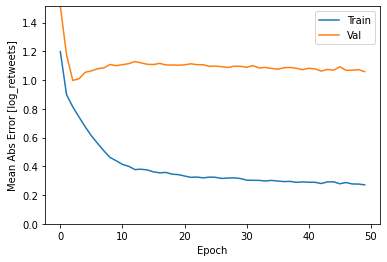

In [84]:
plot_history(deep_hist_2)

train_score = deep_2.evaluate(X_train2, y_train2, verbose = 0) 
# print('Val loss:', score[0]) 
print('Train RMSE:  {:.4}'.format(train_score[2]))

val_score = deep_2.evaluate(X_val2, y_val2, verbose = 0) 
# print('Val loss:', score[0]) 
print('Val RMSE:  {:.4}'.format(val_score[2]))

## Comparing our Second Round of Baselines

Linear Regression Predictions:
Linear Regression Validation RMSE : 0.9385


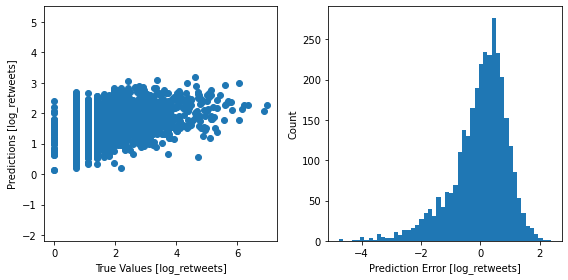

XGBoost Predictions:
XGBoost Validation RMSE : 0.948


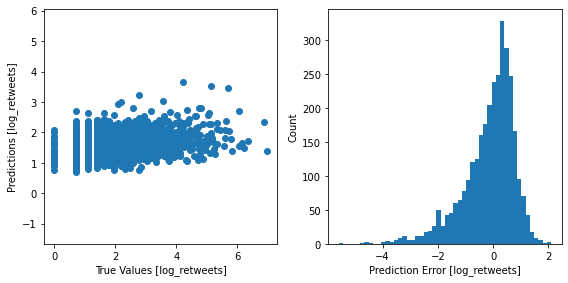

Random Forest Predictions:
RF Validation RMSE : 0.911


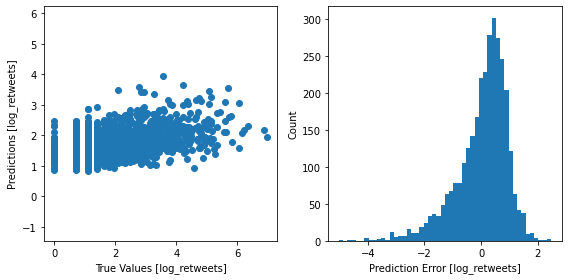

Deep Learning Predictions:
Deep Learning Validation RMSE:  1.047
99/99 [==============================] - 0s 633us/step


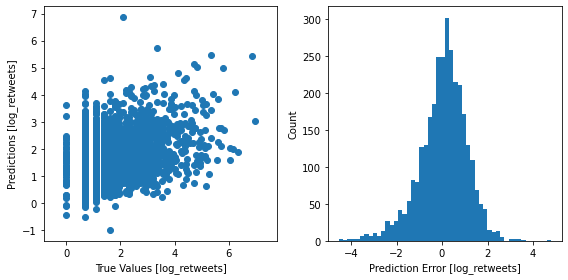

In [85]:
# Comparing all three models
print('Linear Regression Predictions:')
val_predictions = linreg2.predict(X_val2).flatten()
linreg_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("Linear Regression Validation RMSE : {:.4}".format(linreg_rmse))
val_predictions = linreg2.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)
plt.show()

print('XGBoost Predictions:')
val_predictions = XGB2.predict(X_val2).flatten()
xgb_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("XGBoost Validation RMSE : {:.4}".format(xgb_rmse))
val_predictions = XGB2.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)
plt.show()

print('Random Forest Predictions:')
val_predictions = forest2.predict(X_val2).flatten()
forest_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("RF Validation RMSE : {:.4}".format(forest_rmse))
plot_prediction(y_val2, val_predictions)
plt.show()

print('Deep Learning Predictions:')
train_score = deep_2.evaluate(X_train2, y_train2, verbose = 0) 
print('Deep Learning Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = deep_2.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)

Well, we can see some improvements in our RMSE, and most of our baselines did perform better! If we were to choose between Top2Vec and Document Embeddings with PCA, our Document Embeddings probably perform better and contain more data. Let's see if we can improve upon these predictions with some hyperparameter tuning.

# Hyperparameter Tuning
Linear Regression doesn't have hyperparameters to tune, so we'll start with XGBoost

In [86]:
optimize = 'neg_root_mean_squared_error'

In [87]:
eval_metric = ["rmse","mae"]

XGB2 = xgboost.XGBRegressor(objective='reg:squarederror', eval_metric=eval_metric, early_stopping_rounds=6)
XGBhist2 = XGB2.fit(X_train2, y_train2, eval_set=eval_set, )

[0]	validation_0-rmse:1.26521	validation_0-mae:0.87060
[1]	validation_0-rmse:1.12136	validation_0-mae:0.76618
[2]	validation_0-rmse:1.03750	validation_0-mae:0.72122
[3]	validation_0-rmse:0.99113	validation_0-mae:0.70417
[4]	validation_0-rmse:0.96800	validation_0-mae:0.69976
[5]	validation_0-rmse:0.94795	validation_0-mae:0.69144
[6]	validation_0-rmse:0.94139	validation_0-mae:0.69251
[7]	validation_0-rmse:0.93902	validation_0-mae:0.69477
[8]	validation_0-rmse:0.93156	validation_0-mae:0.69313
[9]	validation_0-rmse:0.93036	validation_0-mae:0.69522
[10]	validation_0-rmse:0.92819	validation_0-mae:0.69592
[11]	validation_0-rmse:0.92664	validation_0-mae:0.69444


In [88]:
# Our hyperparameter grid, with some other options as comments

XGB = xgboost.XGBRegressor(objective='reg:squarederror')

XGB_params = {
    'learning_rate' : [0.2],
    'min_child_weight' : [3],
#     'gamma' : [0.0, 0.1, 0.2 , 0.3],
#     'colsample_bytree' : [0.3, 0.4, 0.5],
#     'alpha' : [0.01], # L1 regularization
#     'eta': [1, 0.1, 0.01,],
    'eval_metric':['mlogloss'],
    'lambda':[1], # L2 regularization
#     'booster' : ['gbtree', 'gblinear', 'dart'],
    'max_depth': [7],
    'n_estimators': [100, 150],
#     'subsample': [0.5]
}

start = datetime.datetime.now()

# Searching Parameters
XGB3 = GridSearchCV(XGB, XGB_params, scoring=optimize, refit=optimize, cv=3, n_jobs=1, verbose=True)
XGB3.fit(X_train2, y_train2)

XGB_best_parameters = XGB3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(XGB_best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Grid Search found the following optimal parameters: 
eval_metric: 'mlogloss'
lambda: 1
learning_rate: 0.2
max_depth: 7
min_child_weight: 3
n_estimators: 100
Training took a total of 0:00:45.667593
{}


In [89]:
# Validation RMSE
pred3 = XGB3.predict(X_val2)
xgb_rmse = np.sqrt(MSE(y_val2, pred3))
print("XGB RMSE : % f" %(xgb_rmse))

XGB RMSE :  0.916620


## Random Forest Hyperparameter tuning

In [90]:
# Our hyperparameter grid, with some other options as comments
rf_params = {
    'bootstrap' : [True],
#     'criterion' : ['entropy'], # 'gini', 
    'max_features' : ['auto'],
    'max_depth' : [None],
    'n_estimators' : [100]
}

start = datetime.datetime.now()

# Searching parameters
forest3 = GridSearchCV(RandomForestRegressor(), rf_params, scoring='neg_root_mean_squared_error', cv=2, n_jobs=1)
forest3.fit(X_train2, y_train2)

rf_best_params = forest3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(rf_best_params.keys()):
    print('%s: %r' % (param_name, rf_best_params[param_name]))
    
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Grid Search found the following optimal parameters: 
bootstrap: True
max_depth: None
max_features: 'auto'
n_estimators: 100
Training took a total of 0:05:20.697200


In [91]:
# Validation RMSE
pred3 = forest3.predict(X_val2)
forest_rmse = np.sqrt(MSE(y_val2, pred3))
print("Forest RMSE : % f" %(forest_rmse))

Forest RMSE :  0.917132


## Deep Learning Tuning
Deep Learning is not usually used for tabular data, but let's fiddle around with it a little more and see if we can get better results. We'll also try a 1D CNN, where we trick the CNN to think of our tabular data as image data.

In [92]:
X_train2

,followers,lists,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
2380,0.738906,0.168206,0.189464,-0.278304,0.040095,-0.136290,-0.016943,0.215020,0.235772,0.066923,...,-0.028428,-0.039181,0.001380,0.009837,-0.023183,-0.042216,-0.020111,0.012855,0.014109,-0.004070
30230,0.620544,0.327175,-0.115962,0.418614,-0.002963,0.064523,0.315844,-0.090441,-0.104711,-0.226997,...,0.020100,-0.027454,-0.003872,0.013818,-0.016718,0.008131,-0.021172,-0.003225,-0.021528,-0.003012
1801,0.012727,0.024793,-0.044501,0.312341,0.284731,0.059969,-0.126446,-0.040466,-0.124169,-0.036214,...,0.015680,-0.010017,0.016149,0.028363,-0.011745,0.041380,-0.028732,-0.071920,-0.004127,-0.010586
31911,0.886204,0.406903,-0.083766,0.115864,-0.371840,0.079753,0.135250,0.008940,0.045281,0.008044,...,-0.004786,0.009456,0.011374,-0.051420,0.012188,-0.008504,0.012883,0.015632,0.018997,-0.001448
3711,0.153740,0.177443,0.164243,0.034703,-0.165356,0.065451,-0.000700,0.084136,0.295006,-0.086896,...,-0.021658,-0.010023,0.042438,-0.003872,0.008782,0.013382,0.027935,-0.011926,-0.030409,0.022390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.369464,0.247448,-0.267909,-0.060072,0.005094,-0.089269,0.158497,0.060437,0.095444,-0.087021,...,0.017528,-0.004090,-0.015900,0.036552,-0.006277,-0.033013,0.006512,-0.024535,-0.003338,-0.008352
27281,0.563397,0.225571,-0.164357,0.242475,-0.129535,0.024315,-0.186801,0.026636,0.277702,0.150384,...,-0.059450,-0.018215,-0.022508,0.025499,-0.016668,0.018102,0.008822,0.005976,-0.002374,0.004327
27197,0.563397,0.225571,0.226170,-0.151485,-0.257428,0.166806,0.100113,0.081518,0.179688,-0.064557,...,0.002319,-0.039479,0.007391,0.001641,0.009616,0.009985,0.020370,-0.005463,0.012718,-0.001913
3974,0.734498,0.343704,-0.016326,0.093078,-0.066305,0.053012,0.063670,-0.169542,0.030738,-0.062225,...,-0.081020,0.038703,0.006473,-0.040208,-0.034800,0.008963,0.014929,0.019801,-0.027730,-0.001600


In [93]:
# Establish our metrics
METRICS = [tf.keras.metrics.MeanAbsoluteError(),
           tf.keras.metrics.RootMeanSquaredError()]

In [94]:
def build_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(X_train2.shape[1],)),                  
    keras.layers.Dense(258, activation=tf.nn.crelu), tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=tf.nn.crelu), tf.keras.layers.Dropout(0.05),
    keras.layers.Dense(32, activation=tf.nn.crelu), tf.keras.layers.Dropout(0.05),
    keras.layers.Dense(128, activation=tf.nn.crelu), tf.keras.layers.Dropout(0.05),
    keras.layers.Dense(1)
  ], name="MLP_model")

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=METRICS)
  return model

deep_3 = build_model()
# deep_1.summary()

In [95]:
# Timing
start = datetime.datetime.now()

EPOCHS = 40
# Store training stats
deep_hist_3 = deep_3.fit(X_train2, y_train2, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

# Timing
end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Epoch 1/40
237/237 [==============================] - 1s 3ms/step - loss: 1.0431 - mean_absolute_error: 0.7624 - root_mean_squared_error: 1.0213 - val_loss: 2.5200 - val_mean_absolute_error: 1.2338 - val_root_mean_squared_error: 1.5874
Epoch 2/40
237/237 [==============================] - 1s 3ms/step - loss: 0.7671 - mean_absolute_error: 0.6583 - root_mean_squared_error: 0.8758 - val_loss: 1.6573 - val_mean_absolute_error: 0.9150 - val_root_mean_squared_error: 1.2874
Epoch 3/40
237/237 [==============================] - 1s 3ms/step - loss: 0.6148 - mean_absolute_error: 0.5911 - root_mean_squared_error: 0.7841 - val_loss: 0.9948 - val_mean_absolute_error: 0.7258 - val_root_mean_squared_error: 0.9974
Epoch 4/40
237/237 [==============================] - 1s 3ms/step - loss: 0.4749 - mean_absolute_error: 0.5260 - root_mean_squared_error: 0.6891 - val_loss: 0.9413 - val_mean_absolute_error: 0.7214 - val_root_mean_squared_error: 0.9702
Epoch 5/40
237/237 [==============================] - 1s

Epoch 36/40
237/237 [==============================] - 1s 3ms/step - loss: 0.0959 - mean_absolute_error: 0.2317 - root_mean_squared_error: 0.3097 - val_loss: 0.9418 - val_mean_absolute_error: 0.7036 - val_root_mean_squared_error: 0.9705
Epoch 37/40
237/237 [==============================] - 1s 3ms/step - loss: 0.1019 - mean_absolute_error: 0.2383 - root_mean_squared_error: 0.3192 - val_loss: 0.9228 - val_mean_absolute_error: 0.7072 - val_root_mean_squared_error: 0.9606
Epoch 38/40
237/237 [==============================] - 1s 3ms/step - loss: 0.1012 - mean_absolute_error: 0.2377 - root_mean_squared_error: 0.3181 - val_loss: 0.9384 - val_mean_absolute_error: 0.7096 - val_root_mean_squared_error: 0.9687
Epoch 39/40
237/237 [==============================] - 1s 3ms/step - loss: 0.0932 - mean_absolute_error: 0.2284 - root_mean_squared_error: 0.3053 - val_loss: 0.9343 - val_mean_absolute_error: 0.6990 - val_root_mean_squared_error: 0.9666
Epoch 40/40
237/237 [==============================]

Train RMSE:  0.5096
Val RMSE:  0.9633


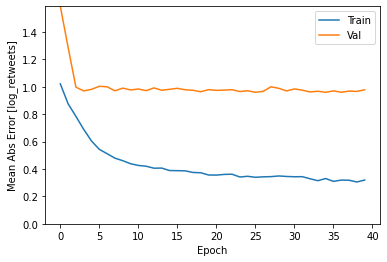

In [96]:
plot_history(deep_hist_3)

train_score = deep_3.evaluate(X_train2, y_train2, verbose = 0) 
# print('Val loss:', score[0]) 
print('Train RMSE:  {:.4}'.format(train_score[2]))

val_score = deep_3.evaluate(X_val2, y_val2, verbose = 0) 
# print('Val loss:', score[0]) 
print('Val RMSE:  {:.4}'.format(val_score[2]))

Deep3 Predictions:
Deep3 Validation RMSE:  0.5096
99/99 [==============================] - 0s 908us/step


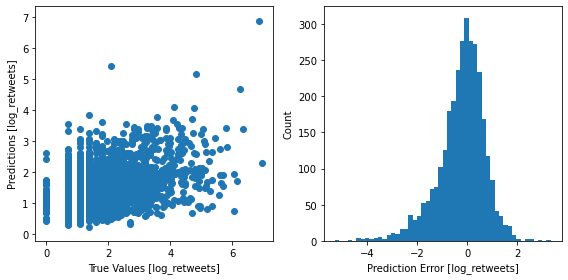

In [97]:
print('Deep3 Predictions:')
val_score = deep_3.evaluate(X_train2, y_train2, verbose = 0) 
print('Deep3 Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = deep_3.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)

We have some improvement here after some experimentation with different neural network structures, but so far I'm unimpressed.

## Conv 1D Model
There's some talk about conv1D models being useful for tabular data, which you could think of it as transforming tabular data into "images" and then identifying spatial relationships between features - I followed the implementation in [this collab](https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing) to see if I could improve on our deep learning baseline, but the model was still outperformed by our tuned XGB.

In [98]:
# Run once to create numpy data
X_train_np = X_train2.to_numpy()
X_val_np = X_val2.to_numpy()
X_test_np = X_test2.to_numpy()

In [99]:
# Reshaping data for Conv1D
input_dimension = 1 # each feature is represented by 1 number

print('X Train Before Reshape:\n', X_train_np.shape)
sample_size = X_train_np.shape[0] # number of samples in train set
time_steps  = X_train_np.shape[1] # number of features in train set
train_data_reshaped = X_train_np.reshape(sample_size,time_steps,input_dimension)
print("After reshape:\n", train_data_reshaped.shape)

sample_size = X_val_np.shape[0] # number of samples in train set
time_steps  = X_val_np.shape[1] # number of features in train set
val_data_reshaped = X_val_np.reshape(sample_size,time_steps,input_dimension)

sample_size = X_test_np.shape[0] # number of samples in train set
time_steps  = X_test_np.shape[1] # number of features in train set
test_data_reshaped = X_test_np.reshape(sample_size,time_steps,input_dimension)

X Train Before Reshape:
 (9460, 258)
After reshape:
 (9460, 258, 1)


In [100]:
# A block for convolution, batch normalization, and pooling
# I'm not sure why there are two conv2d layers in this conv_block, but it does tend to improve performance in testing
def conv_block(neurons):
    conv = tf.keras.Sequential([
        tf.keras.layers.Conv1D(neurons, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(neurons, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    return conv

# A block for densely connected layers with normalization and dropout
def dense_block(neurons, dropout_rate):
    dense = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)])
    return dense

In [101]:
# Establishing learning rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(.8, 50)

# Callbacks
callback_list = [
    keras.callbacks.LearningRateScheduler(exponential_decay_fn)
]

def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1]
  n_features  = train_data_reshaped.shape[2]    
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Dense(256, activation='relu', name="Dense_1"))
  
  tf.keras.layers.BatchNormalization()
  model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  tf.keras.layers.BatchNormalization()
    
#   model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_2"))
  model.add(keras.layers.Dense(n_features, name="Dense_3")),
  keras.layers.Dense(1),

  optimizer = 'adam'

  model.compile(loss='mse',optimizer=optimizer,metrics=METRICS)
  return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 258, 256)          512       
                                                                 
 Conv1D_1 (Conv1D)           (None, 256, 64)           49216     
                                                                 
 Conv1D_2 (Conv1D)           (None, 255, 32)           4128      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 127, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 4064)              0         
                                                                 
 Dense_2 (Dense)             (None, 32)                130080    
                                                                 
 Dense_3 (Dense)             (None, 1)                

In [102]:
EPOCHS = 25
# Store training stats
deep_hist_2 = model_conv1D.fit(train_data_reshaped, y_train2, epochs=EPOCHS, # , callbacks=callback_list
                    validation_split=0.2, verbose=1)

Epoch 1/25
237/237 [==============================] - 7s 29ms/step - loss: 1.1120 - mean_absolute_error: 0.5328 - root_mean_squared_error: 0.7991 - val_loss: 1.0859 - val_mean_absolute_error: 0.7499 - val_root_mean_squared_error: 1.0421
Epoch 2/25
237/237 [==============================] - 7s 28ms/step - loss: 0.9791 - mean_absolute_error: 0.7384 - root_mean_squared_error: 0.9895 - val_loss: 1.0056 - val_mean_absolute_error: 0.7400 - val_root_mean_squared_error: 1.0028
Epoch 3/25
237/237 [==============================] - 7s 28ms/step - loss: 0.9111 - mean_absolute_error: 0.7136 - root_mean_squared_error: 0.9545 - val_loss: 0.9750 - val_mean_absolute_error: 0.7542 - val_root_mean_squared_error: 0.9874
Epoch 4/25
237/237 [==============================] - 7s 28ms/step - loss: 0.8822 - mean_absolute_error: 0.7037 - root_mean_squared_error: 0.9393 - val_loss: 0.9758 - val_mean_absolute_error: 0.7285 - val_root_mean_squared_error: 0.9878
Epoch 5/25
237/237 [==============================] 

Train RMSE:  0.5943
Val RMSE:  1.084


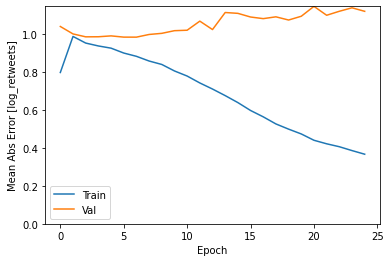

In [103]:
plot_history(deep_hist_2)

train_score = model_conv1D.evaluate(train_data_reshaped, y_train2, verbose = 0) 
print('Train RMSE:  {:.4}'.format(train_score[2]))
val_score = model_conv1D.evaluate(val_data_reshaped, y_val2, verbose = 0) 
print('Val RMSE:  {:.4}'.format(val_score[2]))

Conv 1D Predictions:
Conv 1D Validation RMSE:  1.084
99/99 [==============================] - 1s 8ms/step


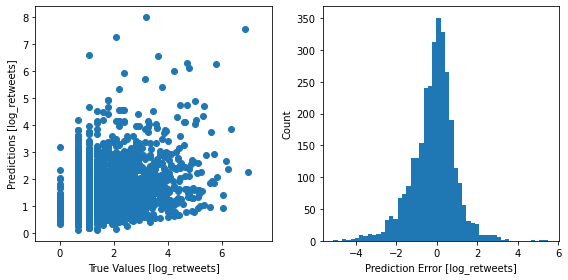

In [104]:
print('Conv 1D Predictions:')
val_score = model_conv1D.evaluate(val_data_reshaped, y_val2, verbose = 0) 
print('Conv 1D Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = model_conv1D.predict(val_data_reshaped)[:, 0]
plot_prediction(y_val2, val_predictions)

## Comparing our tuned models

Linear Regression 2 Predictions (No hyperparameter tuning):
Linear Regression Validation RMSE : 0.9385


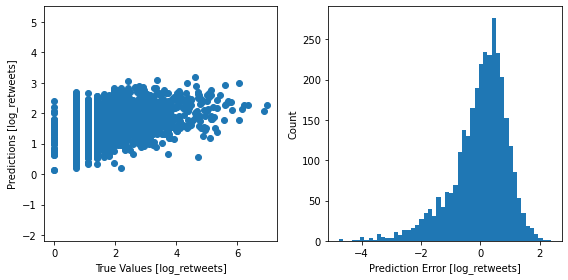

XGBoost Predictions:
XGBoost Validation RMSE : 0.9166


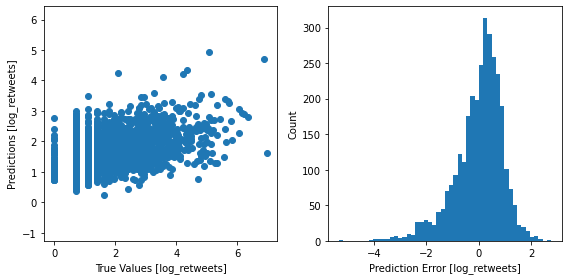

Random Forest Predictions:
RF Validation RMSE : 0.9171


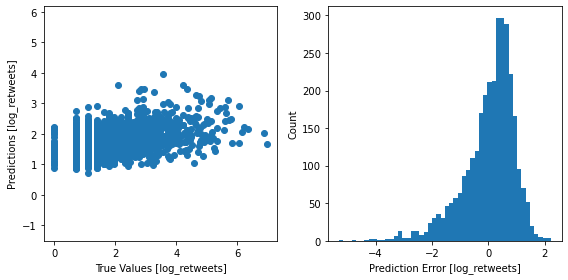

Deep Learning Predictions:
Deep Learning Validation RMSE:  0.9633
99/99 [==============================] - 0s 867us/step


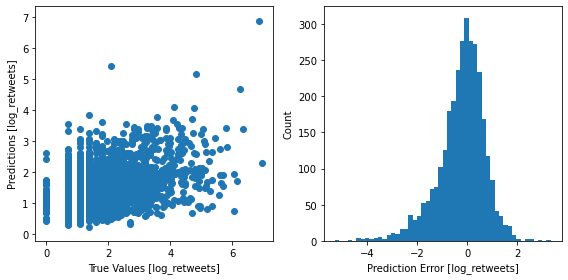

Conv 1D Predictions:
Conv 1D Validation RMSE:  1.084
99/99 [==============================] - 1s 8ms/step


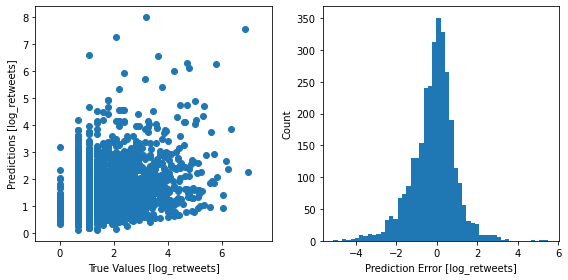

In [106]:
# Comparing all tuned models
print('Linear Regression 2 Predictions (No hyperparameter tuning):')
val_predictions = linreg2.predict(X_val2).flatten()
linreg_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("Linear Regression Validation RMSE : {:.4}".format(linreg_rmse))
val_predictions = linreg2.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)
plt.show()

print('XGBoost Predictions:')
val_predictions = XGB3.predict(X_val2).flatten()
xgb_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("XGBoost Validation RMSE : {:.4}".format(xgb_rmse))
val_predictions = XGB3.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)
plt.show()

print('Random Forest Predictions:')
val_predictions = forest3.predict(X_val2).flatten()
forest_rmse = np.sqrt(MSE(y_val2, val_predictions))
print("RF Validation RMSE : {:.4}".format(forest_rmse))
plot_prediction(y_val2, val_predictions)
plt.show()

print('Deep Learning Predictions:')
val_score = deep_3.evaluate(X_val2, y_val2, verbose = 0) 
print('Deep Learning Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = deep_3.predict(X_val2).flatten()
plot_prediction(y_val2, val_predictions)
plt.show()

print('Conv 1D Predictions:')
val_score = model_conv1D.evaluate(val_data_reshaped, y_val2, verbose = 0) 
print('Conv 1D Validation RMSE:  {:.4}'.format(val_score[2]))
val_predictions = model_conv1D.predict(val_data_reshaped)[:, 0]
plot_prediction(y_val2, val_predictions)
plt.show()

After experimenting with this for a few days, I think it's safe to say that the standard machine learning models are still outperforming our deep learning models on our tabular data. It's also looking like XGBoost and RF are our top models, with XGB having a slight edge on our validation data. I was able to get 1D CNNs to outperform our dense-network deep-learning models on principle components of document embeddings, but not beat XGB or RF. On raw document embeddings we run into longer training times, and seeing the results on principle components, I decided to forgoe further 1D CNN iterations.

It seems that our decision tree algorithms predictably beat out our deep learning models on tabular data. XGB outperformed RF and trained much faster, making this model even more compelling. We will chose that as our final.

## Final Model Evaluation
Let's see how XGB performs on our holdout data:

XGBoost Final Predictions:
Test RMSE : 0.9258


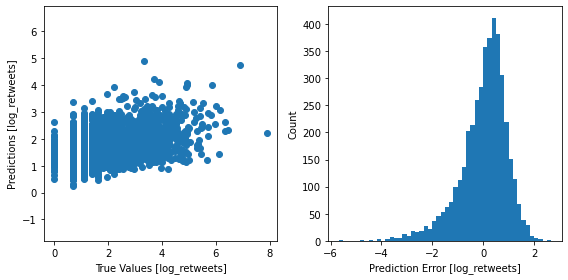

In [107]:
print('XGBoost Final Predictions:')

test_predictions = XGB3.predict(X_test2).flatten()

xgb_rmse = np.sqrt(MSE(y_test2, test_predictions))
print("Test RMSE : {:.4}".format(xgb_rmse))

test_predictions = XGB3.predict(X_test2).flatten()
plot_prediction(y_test2, test_predictions)

plt.show()

This means that on average, our model can predict the retweet count to within about 1 order of magnitude. What does that mean? Most of the time we can now look at a drafted tweet from an account and say whether it's likely to get 1, 10, 100, or 1000 retweets, based on the account and the semantic content of the tweet. That's pretty cool!

Our model is also quite a bit more accurate than just looking at follower counts alone - (check this) 

In [299]:
# Data and Target Split
X3 = df_features[['followers', 'lists']]
y = df_features['retweets'] # This is the same as our original y

# Log transform of y
y_log = np.log1p(y)

# Train-test Split
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(X3, y_log, random_state=42)

# Creating Validation Set
X_train_100, X_val_100, y_train_100, y_val_100 = train_test_split(X_train_100, y_train_100, random_state=42)

In [300]:
linreg_100 = LinearRegression().fit(X_train_100, y_train_100)

print('Training Accuracy: {:.4}%'.format(linreg_100.score(X_train_100, y_train_100) * 100))
print('Validation accuracy: {:.4}%'.format(linreg_100.score(X_val_100, y_val_100) * 100))

pred_100 = linreg_100.predict(X_val_100)
linreg_rmse_100 = np.sqrt(MSE(y_val_100, pred_100))
print("LR RMSE : % f" %(linreg_rmse_100))

Training Accuracy: 7.033%
Validation accuracy: 7.717%
LR RMSE :  0.921444


In [301]:
start = datetime.datetime.now()

progress = dict()
eval_set = [(X_val_100, y_val_100)]
eval_metric = ["rmse","mae"]

XGB100 = xgboost.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=20)
XGBhist100 = XGB100.fit(X_train_100, y_train_100, eval_metric=eval_metric, eval_set=eval_set, )

end = datetime.datetime.now(); elapsed = end-start
print('Training took a total of {}'.format(elapsed))
print(progress)

[0]	validation_0-rmse:1.13898	validation_0-mae:0.75007
[1]	validation_0-rmse:1.00745	validation_0-mae:0.66754
[2]	validation_0-rmse:0.93439	validation_0-mae:0.63149
[3]	validation_0-rmse:0.89358	validation_0-mae:0.61750
[4]	validation_0-rmse:0.87024	validation_0-mae:0.61189
[5]	validation_0-rmse:0.85662	validation_0-mae:0.61085
[6]	validation_0-rmse:0.85047	validation_0-mae:0.61322
[7]	validation_0-rmse:0.84495	validation_0-mae:0.61257
[8]	validation_0-rmse:0.84172	validation_0-mae:0.61272
[9]	validation_0-rmse:0.83931	validation_0-mae:0.61286
[10]	validation_0-rmse:0.83435	validation_0-mae:0.61097
[11]	validation_0-rmse:0.83366	validation_0-mae:0.61147
[12]	validation_0-rmse:0.83288	validation_0-mae:0.61110
[13]	validation_0-rmse:0.83272	validation_0-mae:0.61139
[14]	validation_0-rmse:0.82988	validation_0-mae:0.60966
[15]	validation_0-rmse:0.82859	validation_0-mae:0.60860
[16]	validation_0-rmse:0.82809	validation_0-mae:0.60842
[17]	validation_0-rmse:0.82665	validation_0-mae:0.60727
[1

C:\Users\8D\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:0.81639	validation_0-mae:0.59690
[50]	validation_0-rmse:0.81642	validation_0-mae:0.59690
[51]	validation_0-rmse:0.81630	validation_0-mae:0.59666
[52]	validation_0-rmse:0.81635	validation_0-mae:0.59670
[53]	validation_0-rmse:0.81640	validation_0-mae:0.59667
[54]	validation_0-rmse:0.81634	validation_0-mae:0.59662
[55]	validation_0-rmse:0.81624	validation_0-mae:0.59649
[56]	validation_0-rmse:0.81615	validation_0-mae:0.59640
[57]	validation_0-rmse:0.81617	validation_0-mae:0.59634
[58]	validation_0-rmse:0.81612	validation_0-mae:0.59633
[59]	validation_0-rmse:0.81609	validation_0-mae:0.59630
[60]	validation_0-rmse:0.81602	validation_0-mae:0.59624
[61]	validation_0-rmse:0.81572	validation_0-mae:0.59596
[62]	validation_0-rmse:0.81564	validation_0-mae:0.59587
[63]	validation_0-rmse:0.81560	validation_0-mae:0.59585
[64]	validation_0-rmse:0.81563	validation_0-mae:0.59582
[65]	validation_0-rmse:0.81558	validation_0-mae:0.59572
[66]	validation_0-rmse:0.81542	validation_0-mae:

In [302]:
# Accuracy of training and val sets
print('Training Accuracy: {:.4}%'.format(XGB100.score(X_train_100, y_train_100) * 100))
print('Validation accuracy: {:.3}%'.format(XGB100.score(X_val_100, y_val_100) * 100))

pred100 = XGB100.predict(X_val_100)
xgb_rmse = np.sqrt(MSE(y_val_100, pred100))
print("XGB RMSE : % f" %(xgb_rmse))

Training Accuracy: 29.41%
Validation accuracy: 27.7%
XGB RMSE :  0.815503


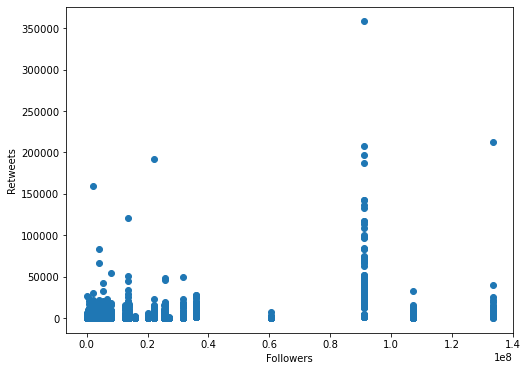

XGBoost Final Predictions:


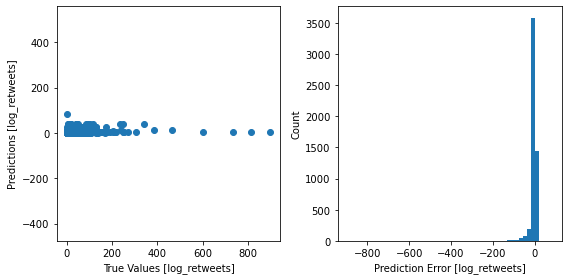

In [123]:
# Follower to Retweet Relationship
follower_to_retweet_curve = plt.figure(figsize=(8, 6))
plt.scatter(df['followers'], df['retweets'])
plt.xlabel('Followers')
plt.ylabel('Retweets')
plt.show()

print('XGBoost Final Predictions:')
plot_prediction(y_val_100, pred100)
plt.show()

In [ ]:
def plot_prediction(test_labels, test_predictions):
  f = plt.figure(figsize=(8, 4))

  f1 = f.add_subplot(1,2,1)
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [log_retweets]')
  plt.ylabel('Predictions [log_retweets]')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())

  error = test_predictions - test_labels
  f2 = f.add_subplot(1,2,2)
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error [log_retweets]")
  plt.ylabel("Count")
    
  plt.tight_layout()
  plt.show()